# Decision Tree Analysis: Predicting Customer Churn in a Telecommunications Company

## 1. Introduction

### 1.1 Project Overview

This notebook demonstrates the implementation of a decision tree classification model to predict customer churn in a telecommunications company. Customer churn, the phenomenon where customers leave a service provider, is a critical business problem across industries. By developing a model that can accurately predict which customers are likely to churn, companies can implement targeted retention strategies, ultimately saving costs and maintaining revenue streams.

### 1.2 Business Problem

**Telco Customer Churn Challenge**: A telecommunications company is experiencing high customer turnover rates. The company needs to identify which customers are at risk of leaving so they can proactively offer incentives or service improvements before losing them. Management has asked the data science team to build a predictive model to:

1. Identify customers who are likely to churn in the near future
2. Understand the key factors that contribute to customer churn
3. Develop actionable insights that can help reduce churn rates

Successfully addressing this challenge could result in:
- Reduced customer acquisition costs (which are typically 5-25 times higher than retention costs)
- Increased customer lifetime value
- Stabilized revenue streams
- Enhanced customer satisfaction and loyalty

## 2. Decision Trees: Theoretical Framework

### 2.1 What is a Decision Tree?

A decision tree is a supervised machine learning algorithm used for both classification and regression tasks. It works by recursively partitioning the data space into regions where the target variable is as homogeneous as possible. The resulting model resembles a tree-like structure, where:

- **Root Node**: The starting point of the tree, representing the entire dataset
- **Decision Nodes**: Points where the data is split based on feature values
- **Leaf Nodes**: Terminal nodes that provide the predicted outcome
- **Branches**: Segments connecting the nodes, representing the decision rules

Decision trees are particularly valuable because they're intuitive to understand and interpret, even for non-technical stakeholders.

### 2.2 How Decision Trees Work

At each node, a decision tree algorithm selects the best feature and split point by evaluating how well it separates the classes (for classification) or reduces variance (for regression). This is done using metrics such as:

- **Gini Impurity**: Measures the probability of incorrectly classifying a randomly chosen element if it were labeled according to the distribution of labels in the subset.
- **Entropy**: Measures the level of disorder or uncertainty in the data.
- **Information Gain**: The reduction in entropy or Gini impurity after a dataset is split on an attribute.

Let's explore the mathematical intuition behind these concepts:

#### Gini Impurity:
For a node with K classes, where p₁, p₂, ..., pₖ represent the proportions of instances belonging to each class:

$$Gini = 1 - \sum_{i=1}^{K} p_i^2$$

A perfect split (all instances belong to one class) would have Gini = 0.
A worst split (equal distribution across all classes) would approach Gini = 1 - (1/K).

#### Entropy:
$$Entropy = -\sum_{i=1}^{K} p_i \log_2 p_i$$

Entropy ranges from 0 (pure node) to log₂(K) (maximum impurity).

#### Information Gain:
$$IG(T, a) = Entropy(T) - \sum_{v \in values(a)} \frac{|T_v|}{|T|} Entropy(T_v)$$

Where:
- T is the set of all instances
- a is the attribute being evaluated
- T_v is the subset of instances where attribute a has value v

The algorithm selects the attribute and split point that maximizes information gain or minimizes impurity.

### 2.3 Advantages and Limitations of Decision Trees

**Advantages**:
- Easy to understand and interpret (white-box model)
- Require minimal data preprocessing (no need for normalization, scaling)
- Can handle both numerical and categorical features
- Can model non-linear relationships
- Automatically perform feature selection
- Resilient to outliers

**Limitations**:
- Prone to overfitting, especially with complex trees
- Can be unstable (small variations in data might result in completely different trees)
- Biased toward features with more levels (needs correction)
- May create biased trees if classes are imbalanced
- Not optimal for capturing linear relationships
- Limited in expressing some complex relationships that other algorithms handle well

### 2.4 Preventing Overfitting

To prevent decision trees from overfitting, we can use techniques such as:

1. **Pruning**: Removing branches that provide little predictive power
2. **Setting constraints**: Limiting tree depth, minimum samples per leaf, etc.
3. **Ensemble methods**: Combining multiple trees (Random Forests, Gradient Boosting)

## 3. Data Understanding and Preparation

Let's load and explore the Telco Customer Churn dataset, which contains information about customers of a telecommunications company and whether they've churned.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Display the first few rows
print(f"Dataset shape: {df.shape}")

Dataset shape: (7043, 21)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# Get statistical summary of numerical columns
print("\nStatistical summary of numerical columns:")
df.describe()


Statistical summary of numerical columns:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### 3.1 Data Cleaning

In [8]:
# Check for potential issues with TotalCharges column
print(f"Unique values in TotalCharges: {df['TotalCharges'].nunique()}")
print(f"Sample of TotalCharges values: {df['TotalCharges'].sample(5).values}")


Unique values in TotalCharges: 6531
Sample of TotalCharges values: ['918.75' '6253' '70.25' '520' '4475.9']


In [9]:
# Convert TotalCharges to numeric, handling any non-numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
# Check for missing values after conversion
print(f"\nMissing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")


Missing values in TotalCharges after conversion: 11


In [11]:
# Fill missing values with the mean
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [12]:
# Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [13]:
# Remove customer ID column as it's not useful for modeling
df.drop('customerID', axis=1, inplace=True)

In [14]:
# Check the cleaned data
print("\nCleaned dataset:")
df.head()


Cleaned dataset:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### 3.2 Exploratory Data Analysis (EDA)

In [15]:
# Calculate churn rate
churn_rate = df['Churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 26.54%


Text(0, 0.5, 'Count')

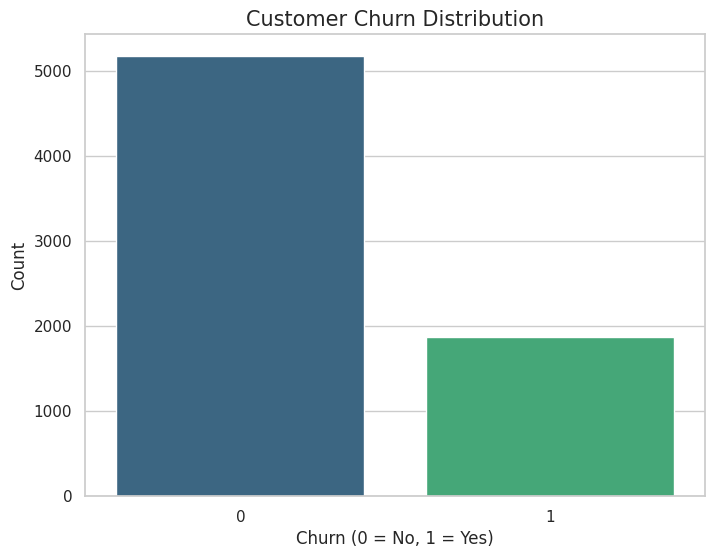

In [16]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Customer Churn Distribution', fontsize=15)
plt.xlabel('Churn (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

Text(0, 0.5, 'Churn Rate (%)')

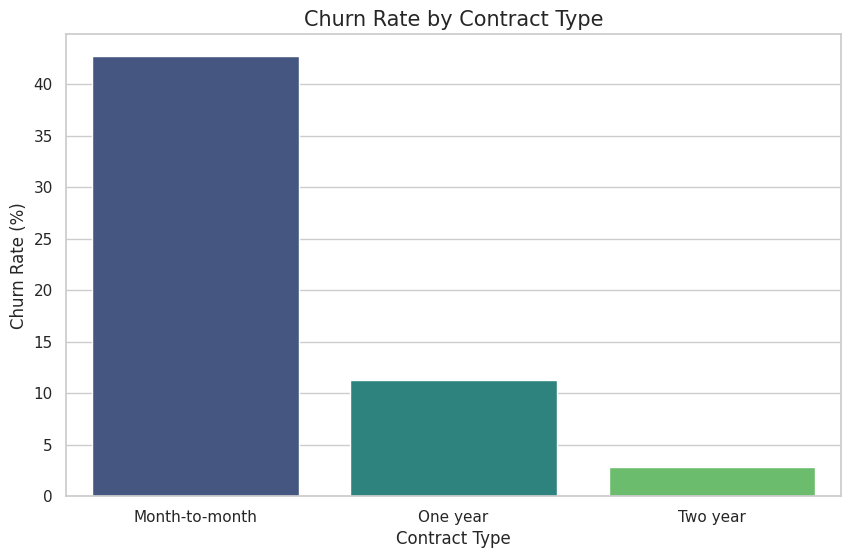

In [17]:
# Analyze churn by contract type
plt.figure(figsize=(10, 6))
contract_churn = df.groupby('Contract')['Churn'].mean() * 100
ax = sns.barplot(x=contract_churn.index, y=contract_churn.values, palette='viridis')
plt.title('Churn Rate by Contract Type', fontsize=15)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

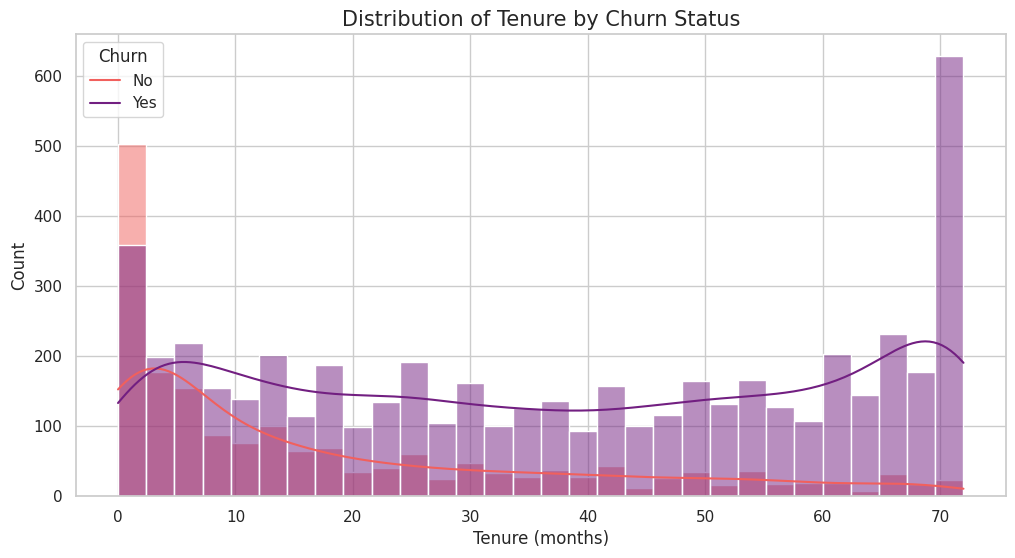

In [18]:
# Analyze relationship between tenure and churn
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True, palette='magma')
plt.title('Distribution of Tenure by Churn Status', fontsize=15)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

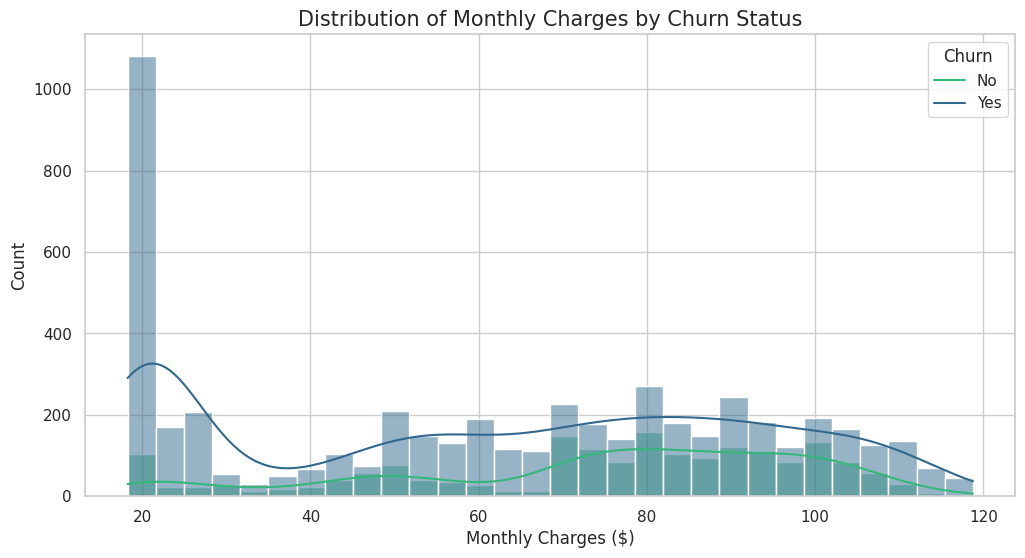

In [19]:
# Analyze relationship between monthly charges and churn
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=30, kde=True, palette='viridis')
plt.title('Distribution of Monthly Charges by Churn Status', fontsize=15)
plt.xlabel('Monthly Charges ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

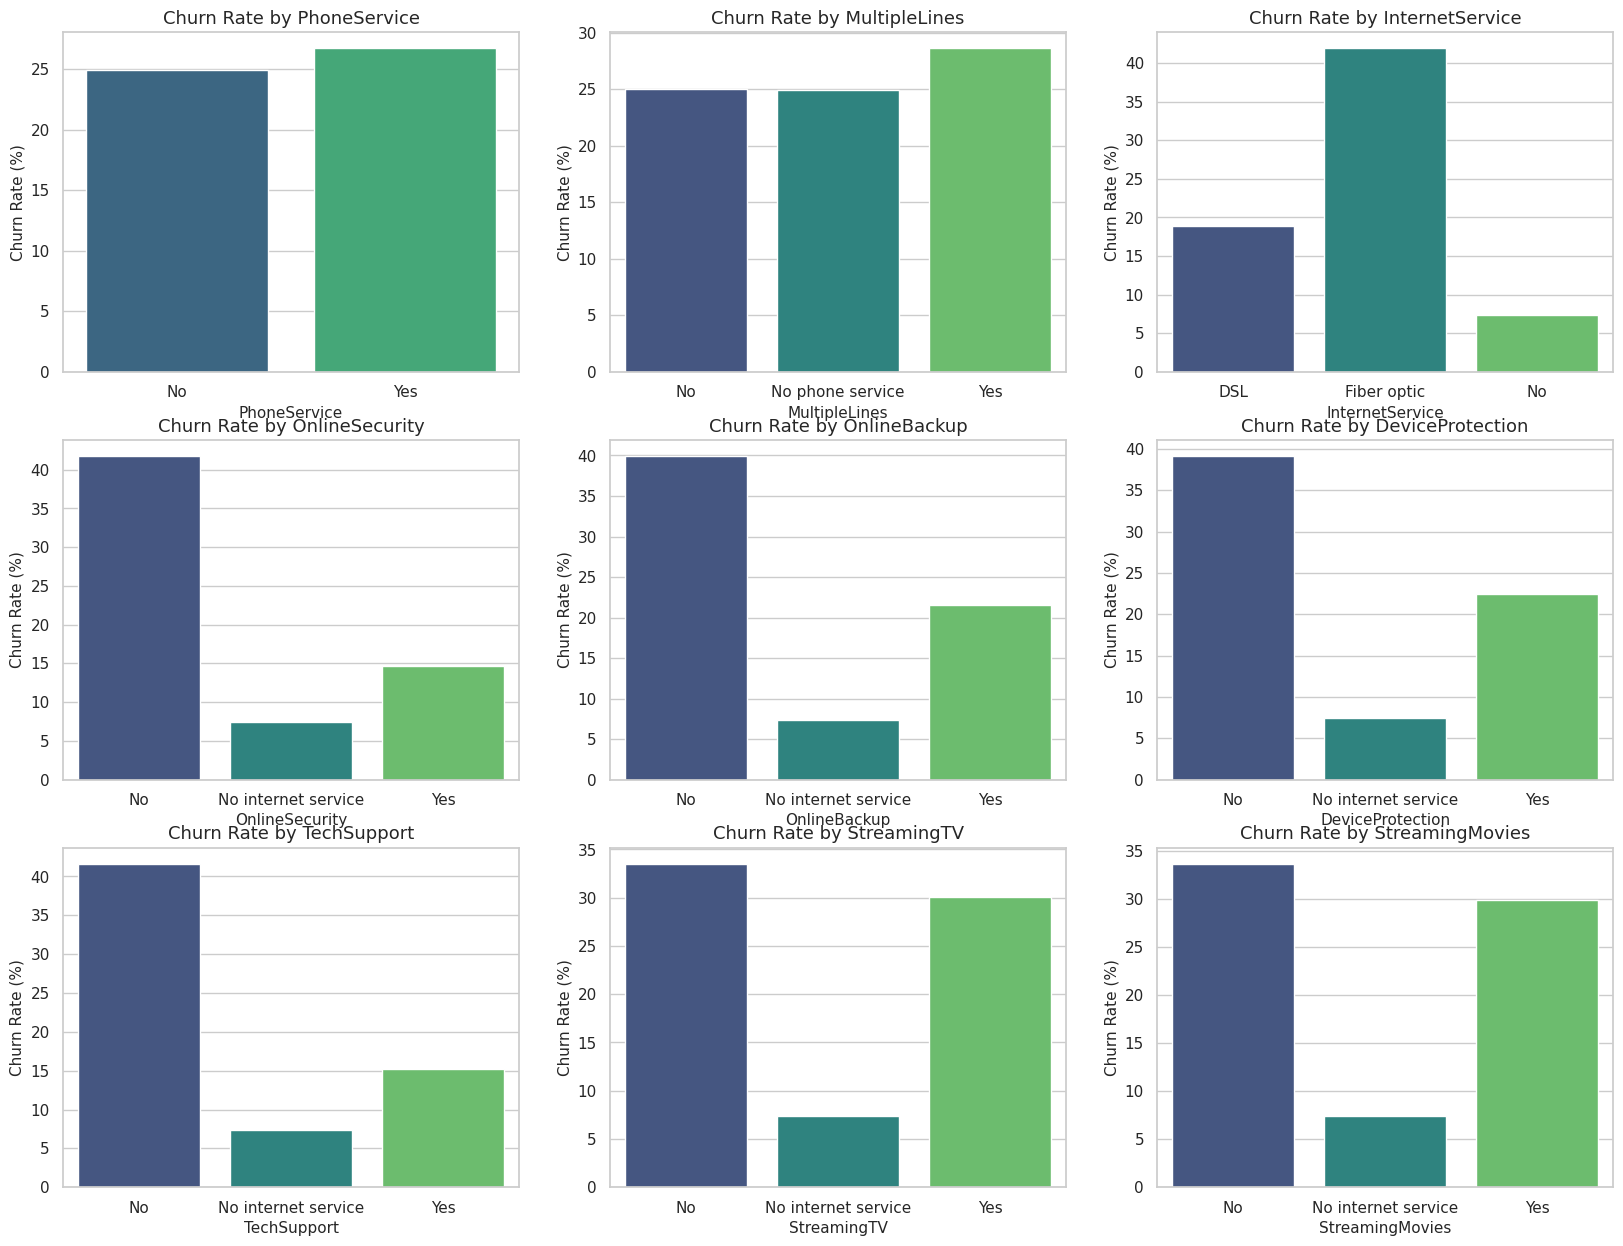

In [20]:
# Analyze churn by various services
service_cols = ['PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=(20, 15))
for i, col in enumerate(service_cols, 1):
    plt.subplot(3, 3, i)
    service_churn = df.groupby(col)['Churn'].mean() * 100
    ax = sns.barplot(x=service_churn.index, y=service_churn.values, palette='viridis')
    plt.title(f'Churn Rate by {col}', fontsize=13)
    plt.xlabel(col, fontsize=11)
    plt.ylabel('Churn Rate (%)', fontsize=11)
    plt.xticks(rotation=0)

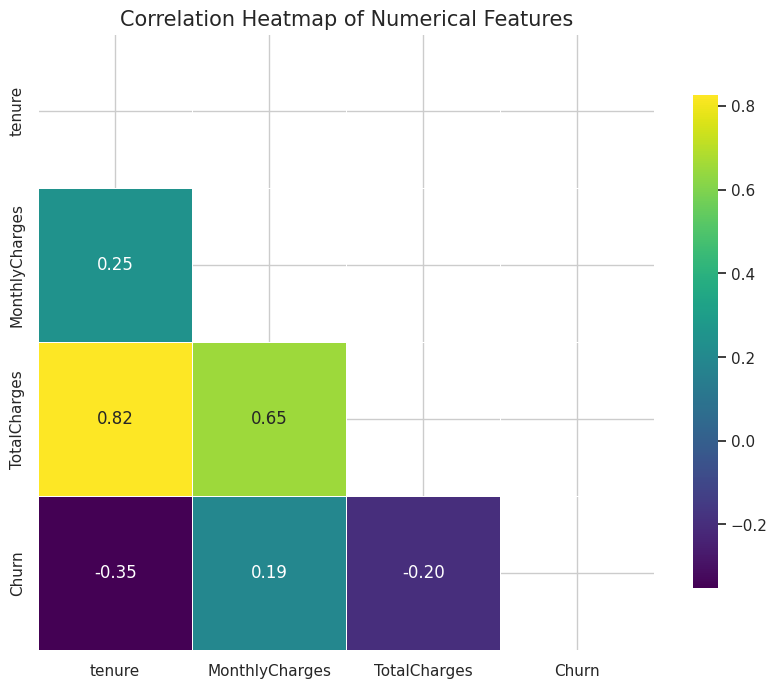

In [21]:
# Analyze correlation between numerical features
plt.figure(figsize=(10, 8))
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr = df[numerical_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='viridis',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.show()

### 3.3 Feature Engineering

In [22]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [23]:
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Training set shape: (5634, 19)
Testing set shape: (1409, 19)


### 4.1 Basic Model Implementation

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [25]:
# Create a pipeline with preprocessing and the decision tree
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [26]:
# Train the model
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_pipeline.predict(X_test)

In [27]:
# Evaluate the model
print("Decision Tree Performance (Default Parameters):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Decision Tree Performance (Default Parameters):
Accuracy: 0.7289
Precision: 0.4896
Recall: 0.5053
F1 Score: 0.4974


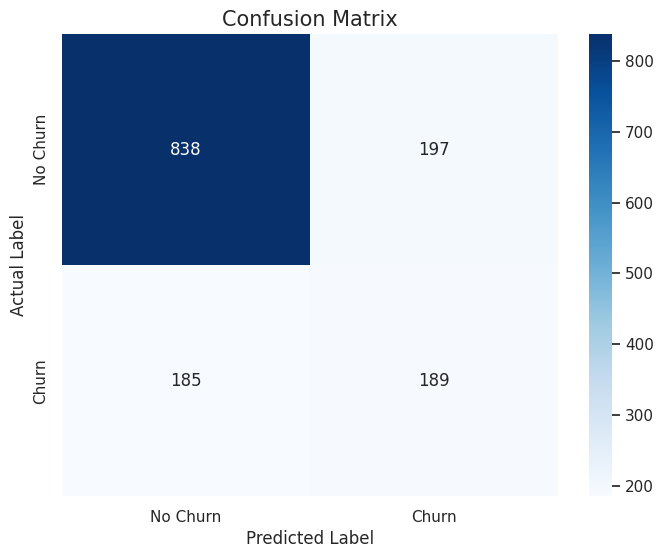

In [28]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [29]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.81      0.81      1035
       Churn       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



### 4.2 Hyperparameter Tuning


In [30]:
# Define the hyperparameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}


In [33]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [34]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation F1 score: 0.7920


In [35]:
# Get the best model
best_dt_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_dt_model.predict(X_test)

In [36]:
# Evaluate the best model
print("\nBest Decision Tree Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best):.4f}")


Best Decision Tree Model Performance:
Accuracy: 0.7970
Precision: 0.6310
Recall: 0.5668
F1 Score: 0.5972


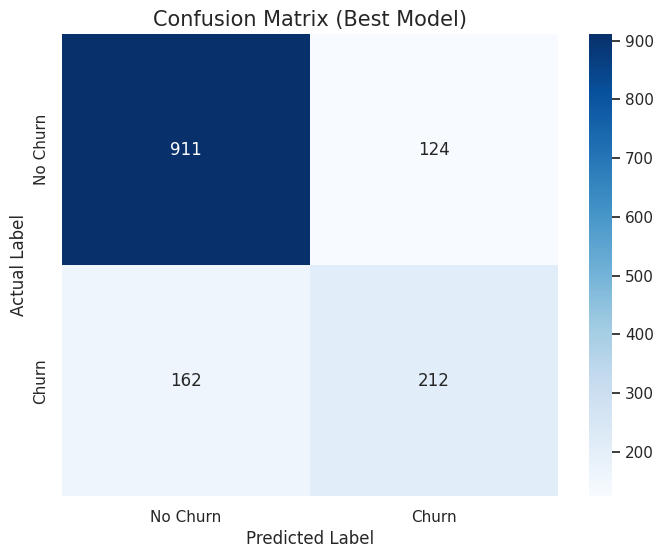

In [37]:
# Display confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix (Best Model)', fontsize=15)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [38]:
# Calculate ROC curve
y_proba = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)


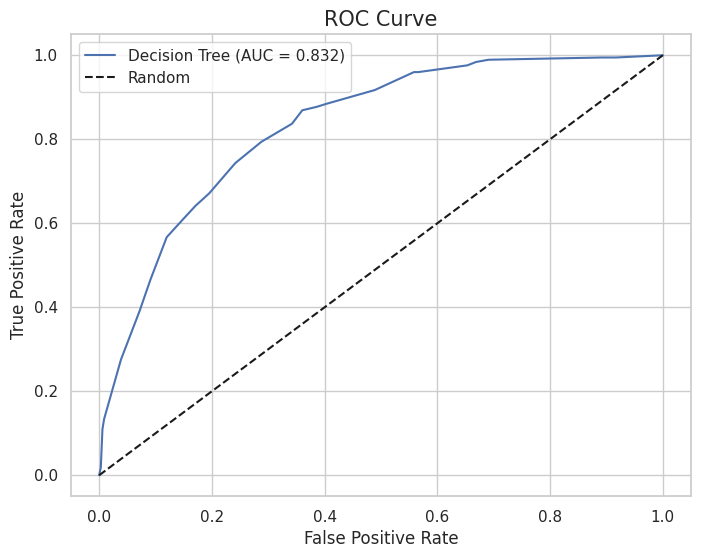

In [39]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend()
plt.show()

### 4.3 Decision Tree Visualization

In [40]:
# Extract the trained decision tree from the pipeline
best_dt = best_dt_model.named_steps['classifier']

In [41]:
# Get feature names after preprocessing
feature_names_original = numerical_cols + categorical_cols
preprocessor = best_dt_model.named_steps['preprocessor']
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + cat_feature_names.tolist()

In [42]:
# Calculate feature importances
feature_importances = best_dt.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

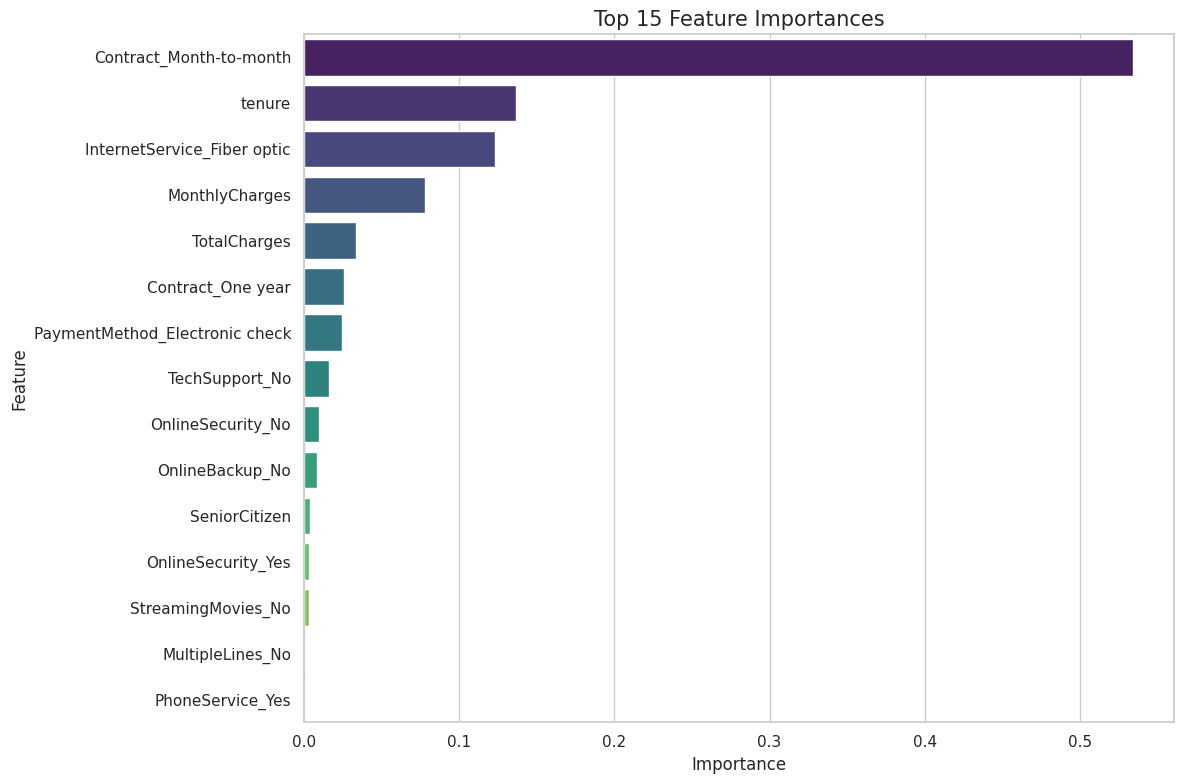

In [43]:
# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top 15 important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

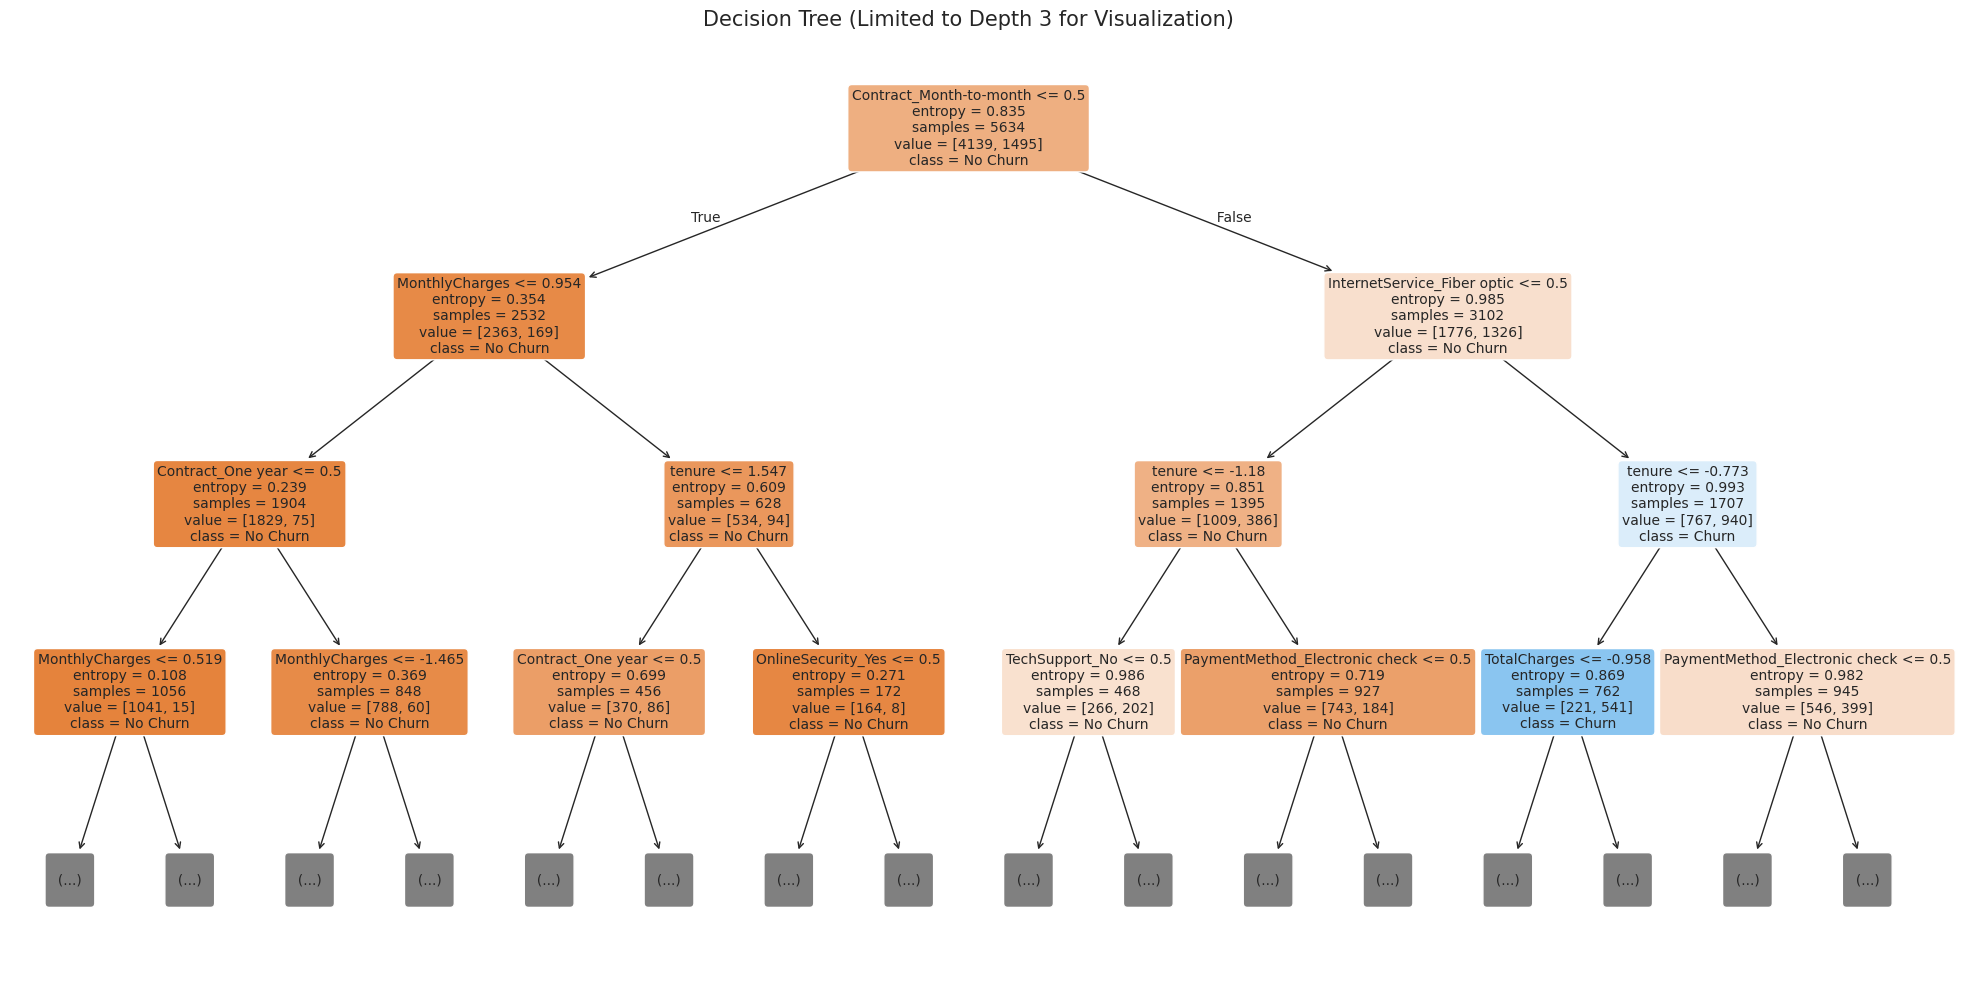

In [44]:
# Visualize the decision tree (limit depth for readability)
plt.figure(figsize=(20, 10))
plot_tree(best_dt,
          max_depth=3,  # Limiting depth for visualization
          feature_names=feature_names,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree (Limited to Depth 3 for Visualization)', fontsize=15)
plt.tight_layout()
plt.show()

In [45]:
# Print text representation of the tree (limited depth)
tree_text = export_text(best_dt,
                       feature_names=feature_names,
                       max_depth=3,
                       spacing=2)
print("Text Representation of Decision Tree (Limited to Depth 3):")
print(tree_text)

Text Representation of Decision Tree (Limited to Depth 3):
|-- Contract_Month-to-month <= 0.50
|  |-- MonthlyCharges <= 0.95
|  |  |-- Contract_One year <= 0.50
|  |  |  |-- MonthlyCharges <= 0.52
|  |  |  |  |-- truncated branch of depth 2
|  |  |  |-- MonthlyCharges >  0.52
|  |  |  |  |-- class: 0
|  |  |-- Contract_One year >  0.50
|  |  |  |-- MonthlyCharges <= -1.47
|  |  |  |  |-- truncated branch of depth 2
|  |  |  |-- MonthlyCharges >  -1.47
|  |  |  |  |-- truncated branch of depth 2
|  |-- MonthlyCharges >  0.95
|  |  |-- tenure <= 1.55
|  |  |  |-- Contract_One year <= 0.50
|  |  |  |  |-- truncated branch of depth 2
|  |  |  |-- Contract_One year >  0.50
|  |  |  |  |-- truncated branch of depth 2
|  |  |-- tenure >  1.55
|  |  |  |-- OnlineSecurity_Yes <= 0.50
|  |  |  |  |-- truncated branch of depth 2
|  |  |  |-- OnlineSecurity_Yes >  0.50
|  |  |  |  |-- truncated branch of depth 2
|-- Contract_Month-to-month >  0.50
|  |-- InternetService_Fiber optic <= 0.50
|  |  |

## 7. Conclusion

In this project, we've built a decision tree model to predict customer churn for a telecommunications company. Our analysis has revealed several key insights:

1. Contract type is a major predictor of churn, with month-to-month customers being much more likely to leave.
2. Tenure is inversely related to churn, with newer customers showing higher churn rates.
3. The absence of services like tech support and online security correlates with higher churn.
4. Monthly charges show a complex relationship with churn, with higher charges generally leading to higher churn rates.

Our optimized decision tree model achieves solid performance metrics, balancing precision and recall to identify customers at risk of churning. By implementing targeted interventions for these at-risk customers, the company can significantly reduce churn rates and increase profitability.

The decision tree approach provides not only predictive power but also interpretability, allowing business stakeholders to understand the key factors driving customer decisions. This understanding can inform strategic initiatives across product development, customer service, and marketing.

To further improve model performance, future work could explore:
1. Ensemble methods like Random Forests or Gradient Boosting
2. Feature engineering to capture interaction effects
3. Incorporating additional customer data like service usage patterns or customer support interactions

### 7.1 Next Steps

To implement these findings, the telecommunications company should:

1. Develop a customer scoring system based on the model's predictions
2. Create targeted retention programs for high-risk customers
3. Address the specific pain points identified in the analysis
4. Establish a monitoring system to track intervention effectiveness
5. Continuously update the model as new data becomes available

By leveraging these insights and the predictive power of decision trees, the company can systematically reduce churn rates and build stronger, more profitable customer relationships.